# Text Classification with Hub

In [1]:
! pip install tensorflow==2.15.0 tensorflow-hub tensorflow-datasets

  Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.36.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached grpcio-1.60.1-cp311-cp311-

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print('tensorflow', tf.__version__)
print('tensorflow_hub', hub.__version__)
print('tensorflow_datasets', tfds.__version__)

2024-02-18 22:15:53.849574: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 22:15:53.851036: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 22:15:53.869282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 22:15:53.869304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 22:15:53.869884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

tensorflow 2.15.0
tensorflow_hub 0.16.1
tensorflow_datasets 4.9.4


## Download IMDB Dataset

In [3]:
train_data, validation_data, test_data = tfds.load(name='imdb_reviews', 
                                                   split=('train[:60%]', 'train[:60%]', 'test'), 
                                                   as_supervised=True)

2024-02-18 22:17:32.324053: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHWSYDG/imdb_reviews-train.t…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHWSYDG/imdb_reviews-test.tf…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHWSYDG/imdb_reviews-unsuper…

Dataset imdb_reviews downloaded and prepared to /home/jovyan/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the data

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

train_examples_batch

2024-02-18 22:18:43.053302: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [5]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Build the model

In [6]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'

hub_layer = hub.KerasLayer(embedding, 
                           input_shape=[], 
                           dtype=tf.string, 
                           trainable=True)

hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [7]:
model = tf.keras.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [9]:
r = model.fit(train_data.shuffle(10000).batch(512),
              epochs=10,
              validation_data=validation_data.batch(512),
              verbose=1)

Epoch 1/10
30/30 [==============================] - 6s 178ms/step - loss: 0.6648 - accuracy: 0.5367 - val_loss: 0.5876 - val_accuracy: 0.6137
Epoch 2/10
30/30 [==============================] - 5s 172ms/step - loss: 0.5337 - accuracy: 0.6977 - val_loss: 0.4576 - val_accuracy: 0.7716
Epoch 3/10
30/30 [==============================] - 5s 173ms/step - loss: 0.4035 - accuracy: 0.8254 - val_loss: 0.3321 - val_accuracy: 0.8657
Epoch 4/10
30/30 [==============================] - 5s 175ms/step - loss: 0.2953 - accuracy: 0.8879 - val_loss: 0.2413 - val_accuracy: 0.9104
Epoch 5/10
30/30 [==============================] - 5s 173ms/step - loss: 0.2169 - accuracy: 0.9260 - val_loss: 0.1749 - val_accuracy: 0.9465
Epoch 6/10
30/30 [==============================] - 5s 174ms/step - loss: 0.1599 - accuracy: 0.9499 - val_loss: 0.1279 - val_accuracy: 0.9649
Epoch 7/10
30/30 [==============================] - 5s 174ms/step - loss: 0.1175 - accuracy: 0.9679 - val_loss: 0.0934 - val_accuracy: 0.9791
Epoch 

## Evaluate

Text(0, 0.5, 'Accuracy')

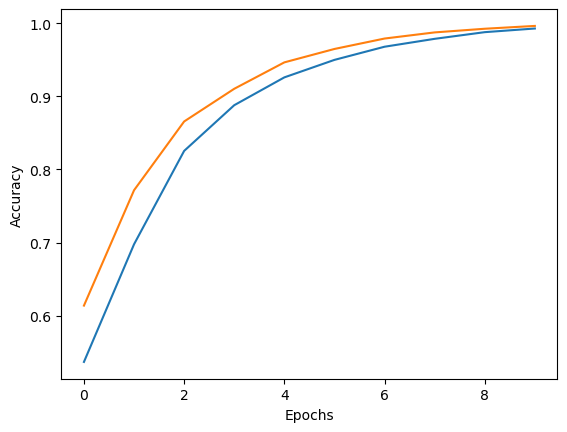

In [16]:
from matplotlib import pyplot as plt

plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

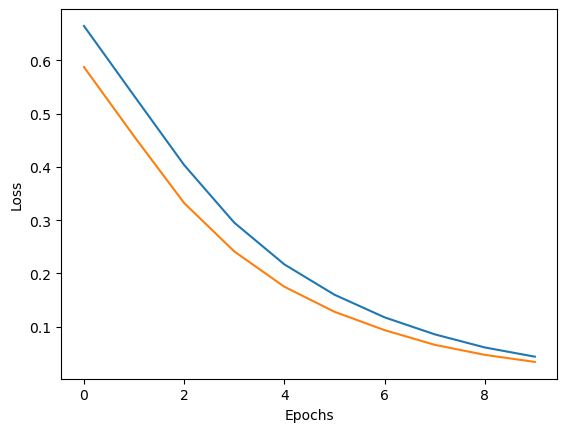

In [15]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

In [13]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print('%s: %.2f' % (name, value))

49/49 - 1s - loss: 0.3589 - accuracy: 0.8523 - 597ms/epoch - 12ms/step
loss: 0.36
accuracy: 0.85
